In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [14]:
PATH = "../data/census/rent/"
df_21 = pd.read_csv(PATH + "median_rent_17to21.csv")
df_16 = pd.read_csv(PATH + "median_rent_12to16.csv")

In [15]:
# White
# Black or African American
# American Indian and Alaska Native
# Asian
# Native Hawaiian and Other Pacific Islander
# Some Other Race alone

def fix_labels(df):
    df["Label (Grouping)"] = df["Label (Grouping)"].map(lambda x: x.lstrip('\xa0'))

    
def get_topics_idcs(df):
    return df[df.isna().any(axis=1)].index


def get_topics(df):
    # Get IDCS of Grouping Rows
    idcs = get_topics_idcs(df)
    idx_pairs = [(idcs[i], idcs[i+1]) if i < (len(idcs) - 1) else (idcs[i],) for i in range(len(idcs))]
    
    # Format the labels
    fix_labels(df)
    
    labels = df.iloc[idcs]["Label (Grouping)"].values
    return list(zip(idx_pairs, labels))


def get_all_sub_dfs(df):
    
    all_subtopics = get_topics(df)
    topic = {}
    subtopics = []
    
    for subtopic_idcs, subtopic in all_subtopics:
        
        if len(subtopic_idcs) == 2:
            topic[subtopic] = df.iloc[subtopic_idcs[0] + 1:subtopic_idcs[1]]
        else:
            topic[subtopic] = df.iloc[subtopic_idcs[0] + 1:]
            
        # Check whether the first row contains values of interest
        if not df.iloc[0].isna().any():
            topic[subtopic].loc[-1] = df.loc[0]                # adding a row
            topic[subtopic].index = topic[subtopic].index + 1  # shifting index
            topic[subtopic] = topic[subtopic].sort_index()     # sorting by index

            
        topic[subtopic] = topic[subtopic].rename(columns={"Label (Grouping)": subtopic})
        topic[subtopic].set_index(subtopic, inplace=True)
        subtopics.append(subtopic)
            
    subtopics = '\n'.join([subtopic for subtopic in subtopics])
    print("The subtopics are:")
    print(subtopics)
    
    return topic


def convert_series_to_int(series):
    new_series = [int("".join(x.split(","))) if type(x) == str else x for x in series.values]
    return np.asarray(new_series)


In [16]:
fix_labels(df_21)
fix_labels(df_16)

dict_21 = get_all_sub_dfs(df_21)
dict_16 = get_all_sub_dfs(df_16)

The subtopics are:

The subtopics are:



In [17]:
def fix_indices(df):
    df.index = df["Label (Grouping)"].values
    df.drop(columns="Label (Grouping)", inplace=True)
    

In [18]:
fix_indices(df_21)
fix_indices(df_16)

In [19]:
curr_list = [df_21, df_16]

for idx in range(len(curr_list)):
    
    # Preprocess data
    all_columns = []
    for column in curr_list[idx].iloc[:-1].columns:
        if "Percent" in column:
            all_columns.append(column)

    curr_list[idx].drop(columns=all_columns, inplace=True)
    curr_list[idx] = curr_list[idx].apply(convert_series_to_int)

    curr_list[idx].columns = [x[1].split(", District")[0][1:] + " - " + x[-1].split("!!")[1] for x in curr_list[idx].columns.str.split("Census")]
    curr_list[idx] = curr_list[idx].iloc[:]

In [20]:
# What would be good to look at?

# 1. Percentage of Tract that is below poverty level
# 2. Percentage of which race makes up which portion of Below poverty level
# 3. Percentage of how many of a race are below poverty level

curr_list[0]

,Tract 64 - Estimate,Tract 102.01 - Estimate,Tract 102.02 - Estimate,Tract 105 - Estimate,Tract 110.01 - Estimate,Tract 110.02 - Estimate
Median contract rent,740,2228,1799,1608,1960,1832


In [21]:
tracts = ["Tract 64", "Tract 102.01", "Tract 102.02", "Tract 105", "Tract 110.01", "Tract 110.02"]
tract_df = curr_list[-1].loc[:, curr_list[-1].columns.str.contains(tracts[0])]
tract_df

,Tract 64 - Estimate
Median contract rent,408


In [67]:
# Get appropriate columns for the data frame
# ------------------------------------------

# ONLY EXECUTE THIS WHEN THE VARIABLE IS ABOUT RACE
labels = np.asarray([x.split(" alone")[0] for x in list(curr_list[0].index)])
new_columns = labels[1:]
new_columns[-1] = "Mixed race"

In [25]:
tract_df

,Tract 64 - Estimate
Median contract rent,408


In [26]:

# Get data
# --------
tracts = ["Tract 64", "Tract 105", "Tract 102.01", "Tract 102.02", "Tract 110.01", "Tract 110.02"]
years = ["2021", "2016"]


tract_dict = {}
for tract in tracts:

    year_dict = {}
    
    for idx, year in enumerate(years):
        
        try:

            tract_df = curr_list[idx].loc[:, curr_list[idx].columns.str.contains(tract)]
            values = tract_df.iloc[0][0]

            # poverty_by_tract[tract] = all_values
            year_dict[year] = values
            
        except IndexError:
            continue
            
    # reverse the dictionary to stay in chronological order
    tract_dict[tract] = dict(reversed(list(year_dict.items())))
    

In [27]:
tract_dict["Tract 64"]

{'2016': 408, '2021': 740}

In [30]:
pd.DataFrame.from_dict(tract_dict["Tract 64"], orient="index", columns=["Median Rent"])

,Median Rent
2016,408
2021,740


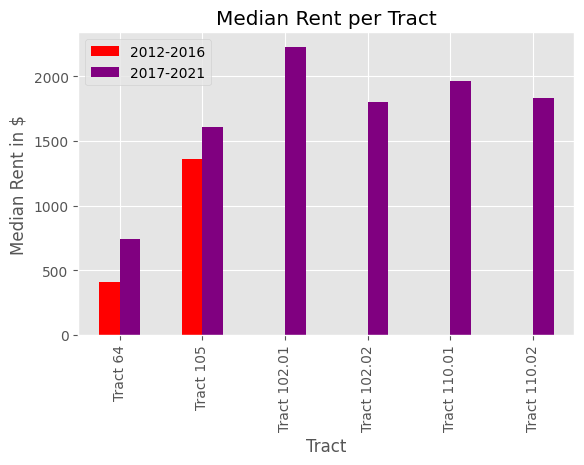

In [38]:
pd.DataFrame.from_dict(tract_dict).T.plot(color=["red", "purple"], kind="bar")
plt.gcf().subplots_adjust(bottom=0.25)
plt.title("Median Rent per Tract")
plt.xlabel("Tract")
plt.ylabel("Median Rent in $")
plt.legend(["2012-2016", "2017-2021"], loc="best")
plt.savefig(f"../plots/rent/all_tracts.png")
